Objective : To predict whether the employee will leave the company or not on the basis of financial habits

# Imports & Functions

In [56]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.decomposition import PCA

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,roc_auc_score
from sklearn.ensemble import RandomForestClassifier

import itertools

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense




Azure  link https://gallery.cortanaintelligence.com/Experiment/Employee-churn

In [ ]:
# def plot_corr(df,size=10):
#     '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

#     Input:
#         df: pandas DataFrame
#         size: vertical and horizontal size of the plot'''

#     corr = df.corr()
#     fig, ax = plt.subplots(figsize=(size, size))
#     ax.legend()
#     cax = ax.matshow(corr)
#     fig.colorbar(cax)
#     plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
#     plt.yticks(range(len(corr.columns)), corr.columns)
    


In [12]:
def calculate_vif(data):
    vif_df = pd.DataFrame(columns = ['Var', 'Vif'])
    x_var_names = data.columns
    for i in range(0, x_var_names.shape[0]):
        y = data[x_var_names[i]]
        x = data[x_var_names.drop([x_var_names[i]])]
        r_squared = sm.OLS(y.astype(float),x.astype(float)).fit().rsquared
        vif = round(1/(1-r_squared),2)
        vif_df.loc[i] = [x_var_names[i], vif]
    return vif_df.sort_values(by = 'Vif', axis = 0, ascending=False, inplace=False)


In [13]:
def make_confusion_matrix(y_true,y_pred,classes=None, figsize=(10,10),text_size=15):
        """
        # Note: The following confusion matrix code is a remix of Scikit-Learn's 
        # plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
        # and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
        """
    
        # Create the confusion matrix
        cm = confusion_matrix(y_true, tf.round(y_pred))
        cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
        n_classes = cm.shape[0]

        # Let's prettify it
        fig, ax = plt.subplots(figsize=figsize)
        # Create a matrix plot
        cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
        fig.colorbar(cax)
        #set labels to classes

        if classes:
            labels = classes
        else:
            labels = np.arange(cm.shape[0])

        # Label the axes
        ax.set(title="Confusion Matrix",
                xlabel="Predicted label",
                ylabel="True label",
                xticks=np.arange(n_classes),
                yticks=np.arange(n_classes),
                xticklabels=labels,
                yticklabels=labels)

        # Set x-axis labels to bottom
        ax.xaxis.set_label_position("bottom")
        ax.xaxis.tick_bottom()

        # Adjust label size
        ax.xaxis.label.set_size(text_size)
        ax.yaxis.label.set_size(text_size)
        ax.title.set_size(text_size)

        # Set threshold for different colors
        threshold = (cm.max() + cm.min()) / 2.

        # Plot the text on each cell
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)
    


# Data visualisation

In [14]:
df=pd.read_csv(r"C:\Users\noname797\Documents\ML_projects\Case_study\Datasets\WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [15]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [16]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())

Rows     :  7043
Columns  :  21

Features : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Missing values :   0

Unique values :  
 customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


In [17]:
df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [18]:
df_copy=df.copy()

In [19]:
df_copy.drop(['customerID','MonthlyCharges', 'TotalCharges', 'tenure'], axis=1, inplace=True)
df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes


In [20]:
summary = pd.concat([pd.crosstab(df_copy[x], df_copy.Churn) for x in df_copy.columns[:-1]], keys=df_copy.columns[:-1])
summary['Churn_Percentage'] = summary['Yes'] / (summary['No'] + summary['Yes'])
summary

Churn                                         No   Yes  Churn_Percentage
gender           Female                     2549   939          0.269209
                 Male                       2625   930          0.261603
SeniorCitizen    0                          4508  1393          0.236062
                 1                           666   476          0.416813
Partner          No                         2441  1200          0.329580
                 Yes                        2733   669          0.196649
Dependents       No                         3390  1543          0.312791
                 Yes                        1784   326          0.154502
PhoneService     No                          512   170          0.249267
                 Yes                        4662  1699          0.267096
MultipleLines    No                         2541   849          0.250442
                 No phone service            512   170          0.249267
                 Yes                        2121   850          0.286099
InternetService  DSL                        1962   459          0.189591
                 Fiber optic                1799  1297          0.418928
                 No                         1413   113          0.074050
OnlineSecurity   No                         2037  1461          0.417667
                 No internet service        1413   113          0.074050
                 Yes                        1724   295          0.146112
OnlineBackup     No                         1855  1233          0.399288
                 No internet service        1413   113          0.074050
                 Yes                        1906   523          0.215315
DeviceProtection No                         1884  1211          0.391276
                 No internet service        1413   113          0.074050
                 Yes                        1877   545          0.225021
TechSupport      No                         2027  1446          0.416355
                 No internet service        1413   113          0.074050
                 Yes                        1734   310          0.151663
StreamingTV      No                         1868   942          0.335231
                 No internet service        1413   113          0.074050
                 Yes                        1893   814          0.300702
StreamingMovies  No                         1847   938          0.336804
                 No internet service        1413   113          0.074050
                 Yes                        1914   818          0.299414
Contract         Month-to-month             2220  1655          0.427097
                 One year                   1307   166          0.112695
                 Two year                   1647    48          0.028319
PaperlessBilling No                         2403   469          0.163301
                 Yes                        2771  1400          0.335651
PaymentMethod    Bank transfer (automatic)  1286   258          0.167098
                 Credit card (automatic)    1290   232          0.152431
                 Electronic check           1294  1071          0.452854
                 Mailed check               1304   308          0.191067

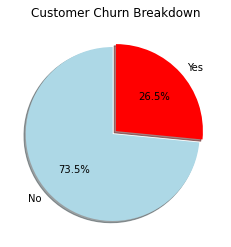

In [21]:
labels = df["Churn"].value_counts(sort=True).index
sizes = df["Churn"].value_counts(sort=True)
colors = ["lightblue","red"]
explode = (0.05,0)

plt.pie(sizes,explode=explode,labels=labels,colors=colors,autopct="%1.1f%%",shadow=True,startangle=90)
plt.title("Customer Churn Breakdown")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


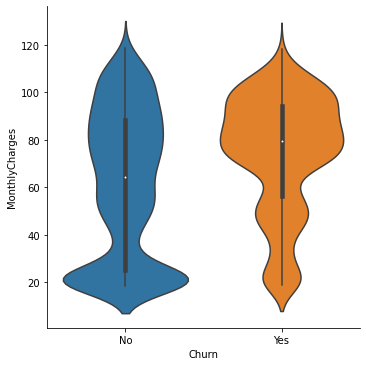

In [22]:
sns.factorplot(x="Churn",y="MonthlyCharges",data=df,kind="violin")

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


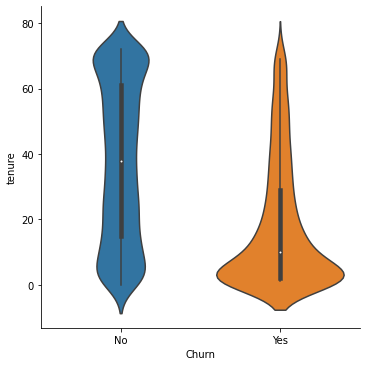

In [23]:
sns.factorplot(x="Churn",y="tenure",data=df,kind="violin")

# Preprocessing

In [24]:
df_copy=df.copy()


In [25]:
len(df_copy[df_copy['TotalCharges'] == " "])

11

In [26]:
df_copy = df_copy[df_copy['TotalCharges'] != " "]

In [27]:
len(df_copy[df_copy['TotalCharges'] == " "])

0

In [28]:
target_col= ["Churn"]

In [29]:
Id_col=["customerID"]

In [30]:
cat_cols = df_copy.nunique()[df_copy.nunique() < 6].keys().tolist()
cat_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [31]:
cat_cols = [x for x in cat_cols if x not in target_col]

In [32]:
num_cols = [x for x in df.columns if x not in cat_cols + target_col + Id_col]
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [33]:
bin_cols = df_copy.nunique()[df_copy.nunique() == 2].keys().tolist()
bin_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [34]:
multi_cols = [i for i in cat_cols if i not in bin_cols]
multi_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [35]:
df_copy

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [36]:
df_copy=df_copy.dropna()

In [37]:
df_copy[df_copy.isnull().any(axis=1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


In [38]:
df_copy.drop(["customerID"],axis=1,inplace=True)
df_copy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [39]:
#since encoding will be the same for both train and test set
encoder_dict={}
for i in bin_cols:
    encoder=LabelEncoder()
    df_copy.loc[:,i]=encoder.fit_transform(df_copy[i])
    mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
    encoder_dict[i]=mapping
    
df_copy=pd.get_dummies(data=df_copy,columns=multi_cols,drop_first=True) # To avoid dummy variable trap


In [40]:
encoder_dict

{'gender': {'Female': 0, 'Male': 1},
 'SeniorCitizen': {0: 0, 1: 1},
 'Partner': {'No': 0, 'Yes': 1},
 'Dependents': {'No': 0, 'Yes': 1},
 'PhoneService': {'No': 0, 'Yes': 1},
 'PaperlessBilling': {'No': 0, 'Yes': 1},
 'Churn': {'No': 0, 'Yes': 1}}

## Co variance plots

<AxesSubplot:title={'center':'Correlation with Churn rate'}>

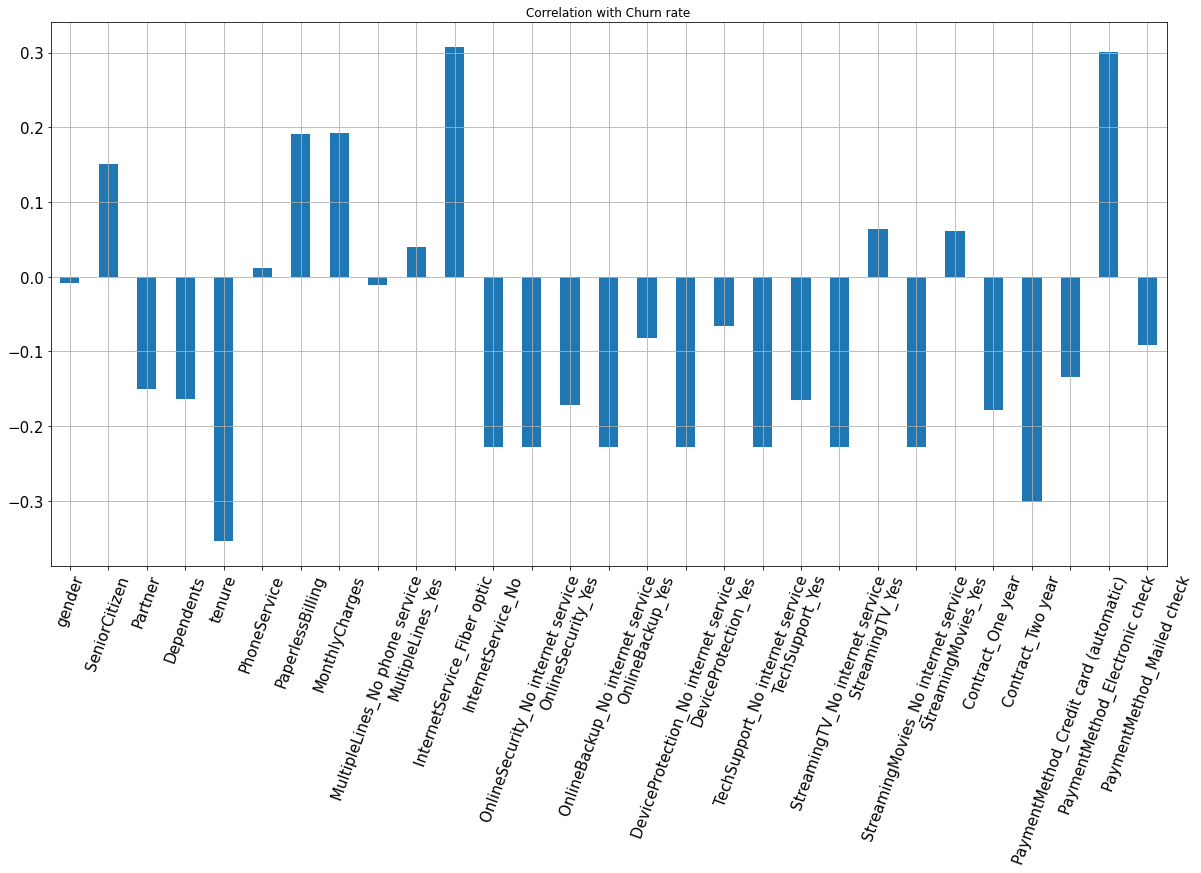

In [41]:
df_churn=df_copy.Churn
df_copy.drop(["Churn"],axis=1).corrwith(df_churn).plot.bar(figsize=(20,10),
                  title = 'Correlation with Churn rate',
                  fontsize = 15, rot = 70,
                  grid = True)

<ipython-input-42-aaf47b4c52ac>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

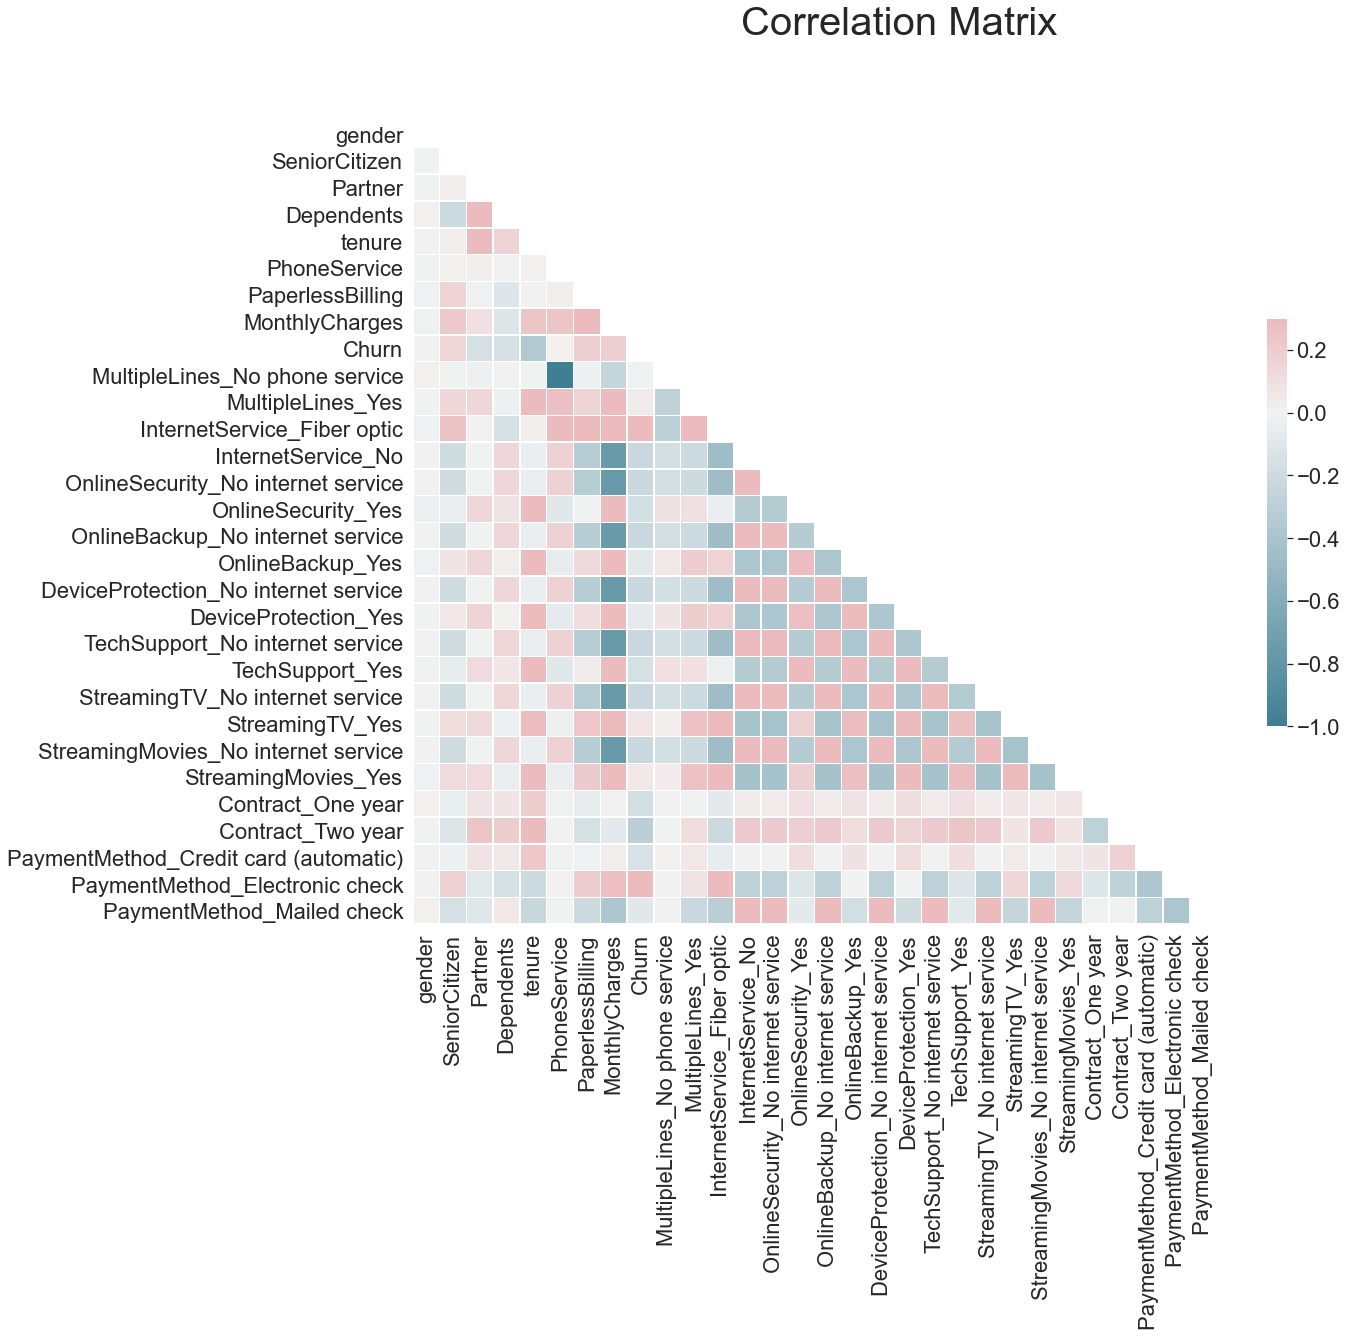

In [42]:

sns.set(style="white", font_scale=2)

corr = df_copy.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(18, 15))
f.suptitle("Correlation Matrix", fontsize = 40)


cmap = sns.diverging_palette(220, 10, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})



# Study of Models 

In [43]:
df_train,df_test= train_test_split(df_copy, test_size=0.2,stratify=df_copy["Churn"])

In [44]:
df_train=df_train.reset_index().iloc[:,1:]
df_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,1,12,1,1,76.60,893,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,3,1,0,19.10,52,0,...,0,1,0,1,0,0,1,0,0,1
2,0,0,0,0,46,1,0,79.20,3593.8,0,...,0,0,1,0,1,0,1,0,0,1
3,0,0,0,0,30,1,0,110.45,3327.05,0,...,1,0,1,0,1,1,0,1,0,0
4,0,0,0,0,25,1,1,78.35,1837.9,0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,1,1,1,0,35,1,1,100.80,3437.5,0,...,0,0,1,0,1,0,0,0,1,0
5621,1,0,1,0,64,1,1,66.15,4392.5,0,...,0,0,1,0,0,1,0,1,0,0
5622,1,0,0,0,1,1,0,20.10,20.1,1,...,0,1,0,1,0,0,0,0,0,1
5623,0,0,1,1,2,0,1,30.25,63.75,0,...,0,0,0,0,0,0,0,0,0,1


In [45]:
df_train["Churn"].value_counts()

0    4130
1    1495
Name: Churn, dtype: int64

In [46]:
df_test["Churn"].value_counts()

0    1033
1     374
Name: Churn, dtype: int64

In [47]:
X_train=df_train.drop(["Churn"],axis=1)
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,0,1,12,1,1,76.60,893,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,1,1,3,1,0,19.10,52,0,...,0,1,0,1,0,0,1,0,0,1
2,0,0,0,0,46,1,0,79.20,3593.8,0,...,0,0,1,0,1,0,1,0,0,1
3,0,0,0,0,30,1,0,110.45,3327.05,0,...,1,0,1,0,1,1,0,1,0,0
4,0,0,0,0,25,1,1,78.35,1837.9,0,...,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,1,1,1,0,35,1,1,100.80,3437.5,0,...,0,0,1,0,1,0,0,0,1,0
5621,1,0,1,0,64,1,1,66.15,4392.5,0,...,0,0,1,0,0,1,0,1,0,0
5622,1,0,0,0,1,1,0,20.10,20.1,0,...,0,1,0,1,0,0,0,0,0,1
5623,0,0,1,1,2,0,1,30.25,63.75,1,...,0,0,0,0,0,0,0,0,0,1


In [48]:
y_train=df_train["Churn"]
y_train

0       0
1       0
2       0
3       0
4       0
       ..
5620    0
5621    0
5622    1
5623    0
5624    0
Name: Churn, Length: 5625, dtype: int32

In [49]:
scaler=StandardScaler()

X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)



In [50]:
X_train_scaled

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No phone service,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.005526,-0.439319,-0.956330,1.533690,-0.829394,0.323534,0.828037,0.388976,-0.609894,-0.323534,...,-0.635999,-0.529296,-0.788059,-0.529296,-0.794892,-0.507212,-0.566333,-0.526543,1.417047,-0.544684
1,-1.005526,-0.439319,1.045664,1.533690,-1.194756,0.323534,-1.207675,-1.515854,-0.979273,-0.323534,...,-0.635999,1.889300,-0.788059,1.889300,-0.794892,-0.507212,1.765747,-0.526543,-0.705693,1.835927
2,-1.005526,-0.439319,-0.956330,-0.652022,0.550861,0.323534,-1.207675,0.475108,0.576336,-0.323534,...,-0.635999,-0.529296,1.268940,-0.529296,1.258032,-0.507212,1.765747,-0.526543,-0.705693,1.835927
3,-1.005526,-0.439319,-0.956330,-0.652022,-0.098671,0.323534,-1.207675,1.510342,0.459175,-0.323534,...,1.572330,-0.529296,1.268940,-0.529296,1.258032,1.971561,-0.566333,1.899179,-0.705693,-0.544684
4,-1.005526,-0.439319,-0.956330,-0.652022,-0.301650,0.323534,0.828037,0.446949,-0.194881,-0.323534,...,1.572330,-0.529296,1.268940,-0.529296,-0.794892,-0.507212,-0.566333,-0.526543,-0.705693,-0.544684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,0.994504,2.276251,1.045664,-0.652022,0.104308,0.323534,0.828037,1.190661,0.507686,-0.323534,...,-0.635999,-0.529296,1.268940,-0.529296,1.258032,-0.507212,-0.566333,-0.526543,1.417047,-0.544684
5621,0.994504,-0.439319,1.045664,-0.652022,1.281584,0.323534,0.828037,0.042794,0.927136,-0.323534,...,-0.635999,-0.529296,1.268940,-0.529296,-0.794892,1.971561,-0.566333,1.899179,-0.705693,-0.544684
5622,0.994504,-0.439319,-0.956330,-0.652022,-1.275948,0.323534,-1.207675,-1.482727,-0.993284,-0.323534,...,-0.635999,1.889300,-0.788059,1.889300,-0.794892,-0.507212,-0.566333,-0.526543,-0.705693,1.835927
5623,-1.005526,-0.439319,1.045664,1.533690,-1.235352,-3.090869,0.828037,-1.146483,-0.974113,3.090869,...,-0.635999,-0.529296,-0.788059,-0.529296,-0.794892,-0.507212,-0.566333,-0.526543,-0.705693,1.835927


Text(0, 0.5, 'cumulative explained variance')

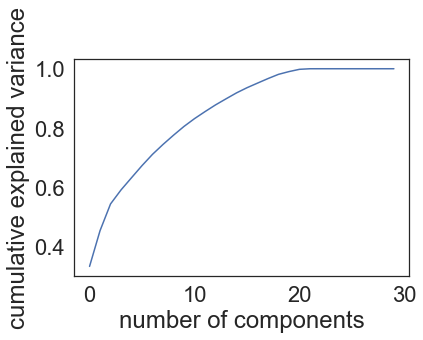

In [51]:
pca = PCA().fit(X_train_scaled,y_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [52]:
pca_X = PCA(n_components=20).fit(X_train_scaled,y_train) # accumulates 98+ percent of variance
principalComponents_X = pca_X.transform(X_train_scaled)

In [53]:
principalComponents_X.shape,y_train.shape

((5625, 20), (5625,))

In [57]:
oversample = SMOTE(k_neighbors=3)
OS_X_train_scaled,OS_y_train = oversample.fit_resample(principalComponents_X, y_train)

In [58]:
OS_y_train.value_counts()

0    4130
1    4130
Name: Churn, dtype: int64

In [59]:
OS_X_train_scaled.shape

(8260, 20)

In [60]:
# Preparing X_test and y_test
df_test=df_test.reset_index().iloc[:,1:]
X_test=df_test.drop(["Churn"],axis=1)
y_test=df_test["Churn"]
X_test_scaled=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

In [61]:
principalComponents_X_test = pca_X.transform(X_test_scaled)

In [62]:
principalComponents_X_test.shape

(1407, 20)

## Logistic regression

In [63]:
model = LogisticRegression()
model.fit(OS_X_train_scaled, OS_y_train)

predictions = model.predict(principalComponents_X_test)
score = model.score(principalComponents_X_test, y_test)

print("Accuracy = " + str(score))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy = 0.7640369580668088
[[790 243]
 [ 89 285]]
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1033
           1       0.54      0.76      0.63       374

    accuracy                           0.76      1407
   macro avg       0.72      0.76      0.73      1407
weighted avg       0.80      0.76      0.77      1407



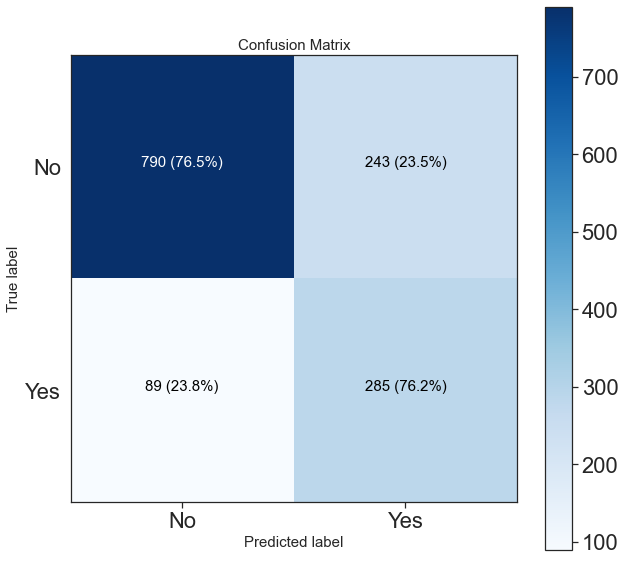

In [64]:
make_confusion_matrix(y_test,predictions,classes=list(encoder.classes_))

In [65]:
roc_auc_score(y_test, predictions)

0.7633974561398968

In [66]:
coef = model.coef_[0]
coef = [abs(number) for number in coef]
print(coef)
# It is pointless here are we are using PCA

[0.1901497171873191, 0.7409696559802201, 0.37263607947400507, 0.18220603953729328, 0.04048612095372967, 0.13193189999961086, 0.04602443634608709, 0.0201759512163889, 0.1726056363019952, 0.3323150469534667, 0.11999548369754628, 0.16142415341652433, 0.08685154508677563, 0.023817514104189638, 0.13760054068239513, 0.25322172274237725, 0.1406559926162589, 0.09547219229674665, 0.5053917157297407, 0.09191348418989198]


## Random forest

 ### Random search of hyperparameters

In [67]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
# Hyper parameter tuning takes a lot of time
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# max_features = ['auto', 'sqrt']

# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)

# min_samples_split = [2, 5, 10]

# min_samples_leaf = [1, 2, 4]

# bootstrap = [True, False]

# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [ ]:
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(OS_X_train_scaled, OS_y_train)

In [ ]:
# rf_random.best_params_

### Base Model

In [68]:
base_model = RandomForestClassifier(n_estimators=1000)
base_model.fit(OS_X_train_scaled, OS_y_train)


RandomForestClassifier(n_estimators=1000)

In [69]:
predictions = base_model.predict(principalComponents_X_test)
score = base_model.score(principalComponents_X_test, y_test)

print("Accuracy = " + str(score))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy = 0.7654584221748401
[[876 157]
 [173 201]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1033
           1       0.56      0.54      0.55       374

    accuracy                           0.77      1407
   macro avg       0.70      0.69      0.70      1407
weighted avg       0.76      0.77      0.76      1407



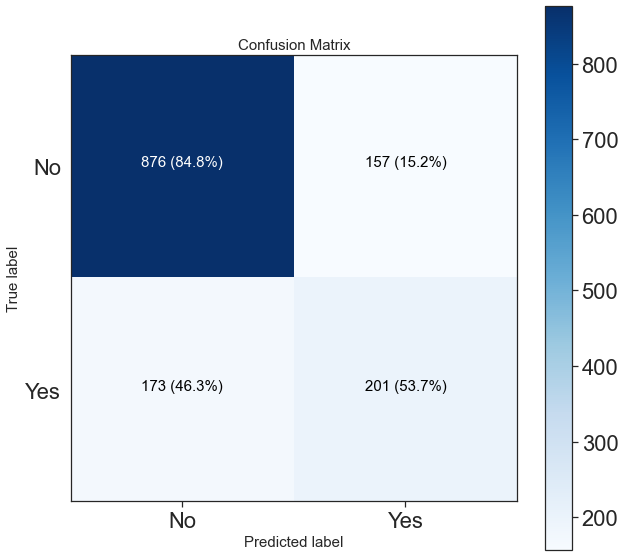

In [70]:

make_confusion_matrix(y_test,predictions,classes=list(encoder.classes_))

In [71]:
roc_auc_score(y_test, predictions)

0.6927243219737953

In [ ]:
# best_random = rf_random.best_estimator_
# best_random.fit(OS_X_train_scaled, OS_y_train)
# predictions = best_random.predict(principalComponents_X_test)
# score = best_random.score(principalComponents_X_test, y_test)

# print("Accuracy = " + str(score))
# print(confusion_matrix(y_test, predictions))
# print(classification_report(y_test, predictions))

### Grid search of Hyperparameters

In [ ]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }

# rf = RandomForestClassifier()

# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# grid_search.fit(OS_X_train_scaled, OS_y_train)
# grid_search.best_params_

In [ ]:
# # Fit the grid search to the data

# best_grid = grid_search.best_estimator_
# best_grid.fit(OS_X_train_scaled, OS_y_train)

In [ ]:
# predictions = best_grid.predict(principalComponents_X_test)
# score = base_model.score(principalComponents_X_test, y_test)

# print("Accuracy = " + str(score))
# print(confusion_matrix(y_test, predictions))
# print(classification_report(y_test, predictions))

## Deep learning

In [72]:
model = Sequential([
    Dense(256,activation = "relu"),
    Dense(128,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(1,activation = "sigmoid")
])



In [73]:
model.compile(optimizer= "adam",loss = "binary_crossentropy",metrics = ["accuracy"])

In [74]:

batch_size = 32
epochs = 25

history = model.fit(OS_X_train_scaled,
                    OS_y_train,
                    batch_size = batch_size, 
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (principalComponents_X_test, y_test))

score = model.evaluate(principalComponents_X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/25
259/259 [==============================] - 1s 5ms/step - loss: 0.4827 - accuracy: 0.7672 - val_loss: 0.4880 - val_accuracy: 0.7534
Epoch 2/25
259/259 [==============================] - 1s 3ms/step - loss: 0.4459 - accuracy: 0.7915 - val_loss: 0.5101 - val_accuracy: 0.7363
Epoch 3/25
259/259 [==============================] - 1s 3ms/step - loss: 0.4281 - accuracy: 0.8029 - val_loss: 0.5048 - val_accuracy: 0.7534
Epoch 4/25
259/259 [==============================] - 1s 3ms/step - loss: 0.4103 - accuracy: 0.8120 - val_loss: 0.4944 - val_accuracy: 0.7520
Epoch 5/25
259/259 [==============================] - 1s 3ms/step - loss: 0.3872 - accuracy: 0.8242 - val_loss: 0.5375 - val_accuracy: 0.7413
Epoch 6/25
259/259 [==============================] - 1s 3ms/step - loss: 0.3686 - accuracy: 0.8367 - val_loss: 0.5318 - val_accuracy: 0.7562
Epoch 7/25
259/259 [==============================] - 1s 3ms/step - loss: 0.3464 - accuracy: 0.8447 - val_loss: 0.5684 - val_accuracy: 0.7427
Epoch 

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 46,593
Trainable params: 46,593
Non-trainable params: 0
_________________________________________________________________


In [76]:
predictions = model.predict(principalComponents_X_test)
predictions = np.round(predictions)

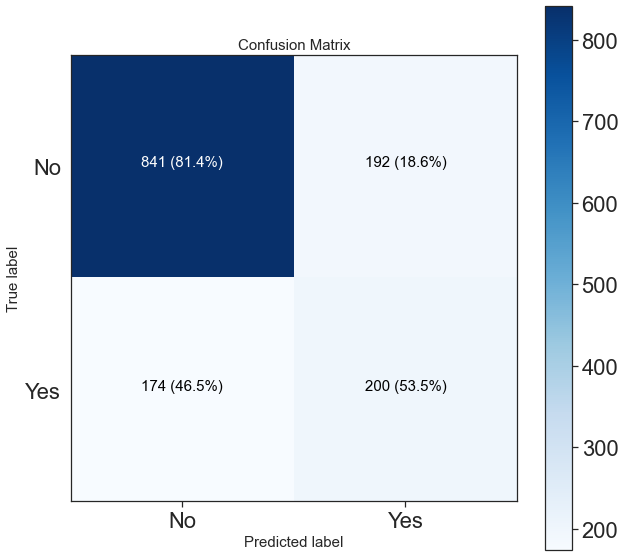

In [77]:
make_confusion_matrix(y_test,predictions,classes=list(encoder.classes_))

In [78]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1033
           1       0.51      0.53      0.52       374

    accuracy                           0.74      1407
   macro avg       0.67      0.67      0.67      1407
weighted avg       0.74      0.74      0.74      1407



In [79]:
roc_auc_score(y_test, predictions)

0.6744464748849465